In [1]:
import torch
from torch.optim.lr_scheduler import StepLR
import numpy
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, random_split
import numpy as np
import csv
import time
from livelossplot import PlotLosses
from tqdm import tqdm
import random
from transformers import AlbertModel, AlbertForSequenceClassification, AlbertTokenizer, AdamW
from sklearn.metrics import precision_recall_fscore_support

In [2]:
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')

In [3]:
if torch.cuda.is_available():    
    device = torch.device("cuda:0")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla M40 24GB


In [4]:
device

device(type='cuda', index=0)

In [5]:
def get_dataloader(data_file, batch_size, max_len, portion=0.75):
    torch.manual_seed(0)
    labels = []
    sentences = []
    print("loading data ...")
    with open(data_file) as csv_file:
        reader = csv.reader(csv_file)
        next(reader) # skip first row
        for row in reader:
            labels.append(int(row[0]))
            sentences.append([row[2], row[1]])
    
    input_ids = []
    type_ids = []
    attention_mask = []
    print("Encoding sentences ...")
    for sent in tqdm(sentences):
        input_ = tokenizer.encode_plus(sent[0], sent[1], max_length=max_len, 
                                       pad_to_max_length=True, return_token_type_ids=True, 
                                       return_attention_mask=True, return_tensors = 'pt')
        input_ids.append(input_["input_ids"])
        type_ids.append(input_["token_type_ids"])
        attention_mask.append(input_["attention_mask"])
    
    print("Get dataloader ...")
    input_ids = torch.cat(input_ids, dim=0)
    print(input_ids.shape)
    attention_mask = torch.cat(attention_mask, dim=0)
    type_ids = torch.cat(type_ids, dim=0)
    labels = torch.tensor(labels)
    
    dataset = TensorDataset(input_ids, labels, attention_mask, type_ids)
    print(len(dataset))
    train_size = int(portion * len(dataset))
    val_size = len(dataset) - train_size
    print(train_size, val_size)
    train_data, validation_data = random_split(dataset, [train_size, val_size])
    
    train_dataloader = DataLoader(train_data, sampler=RandomSampler(train_data), batch_size=batch_size)
    validation_dataloader = DataLoader(validation_data, sampler=SequentialSampler(validation_data), batch_size=batch_size)
    print(len(train_dataloader), len(validation_dataloader))
    
    return train_dataloader, validation_dataloader

In [6]:
data_file = "combine_balanced.csv"
BATCH = 32
MAX_LEN = 256
EPOCHS = 5
EARLY_STOP = 1
LR = 1e-5
# LR = 5e-6
# WD = 1e-2
WD = 1e-3
# WD = 1e-4
EPS = 1e-8

In [7]:
train_dataloader, validation_dataloader = get_dataloader(data_file, BATCH, MAX_LEN)

loading data ...


  0%|          | 167/101082 [00:00<01:00, 1665.44it/s]

Encoding sentences ...


100%|██████████| 101082/101082 [00:50<00:00, 2010.43it/s]


Get dataloader ...
torch.Size([101082, 256])
101082
75811 25271
2370 790


In [8]:
classifier = AlbertForSequenceClassification.from_pretrained('albert-base-v2')
classifier.config.classifier_dropout_prob = 0.1
no_decay = ['bias', 'LayerNorm.weight']

optimizer_grouped_parameters = [
    # Filter for all parameters which *don't* include 'bias', 'gamma', 'beta'.
    {'params': [p for n, p in classifier.named_parameters() if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': WD},
    
    # Filter for parameters which *do* include those.
    {'params': [p for n, p in classifier.named_parameters() if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr = LR, eps = EPS)

# optimizer = AdamW(classifier.parameters(), lr = LR, eps = EPS)

total_steps = len(train_dataloader)

# Create the learning rate scheduler.
# scheduler = get_linear_schedule_with_warmup(optimizer, 
#                                             num_warmup_steps = 0, # Default value in run_glue.py
#                                             num_training_steps = total_steps)
scheduler = StepLR(optimizer, step_size=total_steps, gamma=0.95)

In [11]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [10]:
def trainer(classifier, optimizer, scheduler, epochs, early_stop, train_dataloader, validation_dataloader, seed_val=0, accumulation_steps=1):
    if torch.cuda.device_count() > 1:
        print("Let's use", torch.cuda.device_count(), "GPUs!")
        classifier = nn.DataParallel(classifier)
    classifier.to(device)

    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)
    best = (np.inf, -1, -np.inf, None, None)

    liveloss = PlotLosses()
    LossHistory = []
    for epoch_i in range(0, epochs):
        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print("Global Learning Rate", optimizer.param_groups[0]["lr"])
        print('Training...')
        classifier.train()
        epoch_loss = 0.
        start = time.time()
        classifier.zero_grad()
        for step, batch in enumerate(train_dataloader):
            logs = {}
            b_inputs = batch[0].to(device)
            b_labels = batch[1].to(device)
            b_mask = batch[2].to(device)
            b_ids = batch[3].to(device)
            
            loss, logits = classifier(input_ids=b_inputs, attention_mask=b_mask, token_type_ids=b_ids, labels=b_labels)

            if torch.cuda.device_count() > 1:
                loss = loss.sum()
            loss.backward()
            if (step + 1) % accumulation_steps == 0:
                torch.nn.utils.clip_grad_norm_(classifier.parameters(), 1.0)
                optimizer.step()
                scheduler.step()
                classifier.zero_grad()
                
            batch_loss = loss.cpu().item()
            epoch_loss += loss.cpu().item()
            
            if (step % 100 == 0):
                print("Step %i with loss %f elapsed time %f" % (step, batch_loss, time.time() - start))

        print('Evaluating...')
        classifier.eval()
        dev_loss = 0.
        total_eval_accuracy = 0.
        y_preds = None
        y_true = None
        for batch in validation_dataloader:
            b_inputs = batch[0].to(device)
            b_labels = batch[1].to(device)
            b_mask = batch[2].to(device)
            b_ids = batch[3].to(device)
            
            with torch.no_grad():
                loss, logits = classifier(input_ids=b_inputs, attention_mask=b_mask, token_type_ids=b_ids, labels=b_labels)
                if torch.cuda.device_count() > 1:
                    loss = loss.sum()
                    
            dev_loss += loss.cpu().item()
            label_ids = b_labels.cpu().numpy()
            logits = logits.detach().cpu().numpy()
            total_eval_accuracy += flat_accuracy(logits, label_ids)           
            if y_preds is None:
                y_preds = np.argmax(logits, axis=1)
                y_true = label_ids
            else:
                y_preds = np.concatenate((y_preds, np.argmax(logits, axis=1)))
                y_true = np.concatenate((y_true, label_ids))
        
        avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)  
        f1_score_1 = precision_recall_fscore_support(y_true, y_preds, average="binary")
        f1_score_0 = precision_recall_fscore_support(y_true, y_preds, average="binary", pos_label=0)

        print("Epoch %i with dev loss %f and dev accuracy %f" % (epoch_i, dev_loss, avg_val_accuracy))
        logs["val_loss"] = dev_loss / len(validation_dataloader)
        logs["loss"] = epoch_loss / len(train_dataloader)
        logs["val_accuracy"] = avg_val_accuracy
        liveloss.update(logs)
        LossHistory.append(logs["loss"])
        liveloss.send()

        if(epoch_i-best[1] >= early_stop and best[0] < dev_loss):
            print("early_stopping, epoch:", epoch_i+1)
            break
        elif(best[0] > dev_loss):
            best = (dev_loss, epoch_i, avg_val_accuracy, f1_score_1, f1_score_0)
            torch.save(classifier.state_dict(), 'checkpoint_ALBERT.pt')
        
    print("Final dev loss %f Final Train Loss %f Final dev accuracy %f" % (dev_loss, epoch_loss, avg_val_accuracy))
    print("Best dev loss %f Best dev accuracy %f" % (best[0], best[2]))
    print("F1_score Sarcasm ", f1_score_1)
    print("F1_score Non-Sarcasm ", f1_score_0)
    
    return classifier, LossHistory

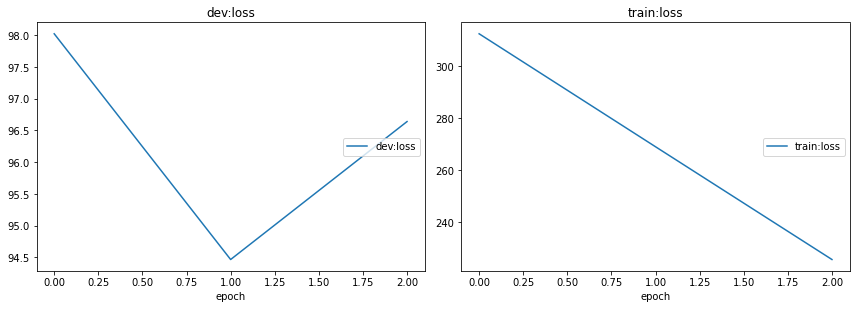

dev:loss
	dev:loss         	 (min:   94.465, max:   98.021, cur:   96.638)
train:loss
	train:loss       	 (min:  225.664, max:  312.465, cur:  225.664)
early_stopping, epoch: 3
Final dev loss 96.638363 Final Train Loss 225.663715 Final dev accuracy 0.676752
Best dev loss 94.465266 Best dev accuracy 0.683519
F1_score Sarcasm  (0.6724821570182395, 0.6833199033037872, 0.6778577138289369, None)
F1_score Non-Sarcasm  (0.6828087167070218, 0.6719618745035743, 0.677341873498799, None)


In [11]:
# weight decay and clip_grad_norm 10K data LR = 5e-6 WD = 1e-3
classifier, history = trainer(classifier, optimizer, scheduler, EPOCHS, EARLY_STOP, train_dataloader, validation_dataloader)

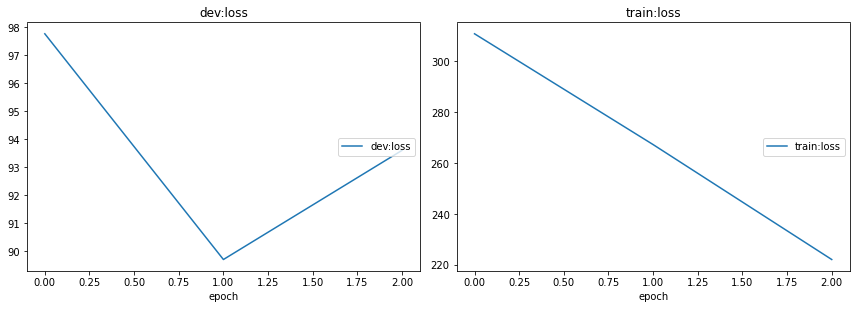

dev:loss
	dev:loss         	 (min:   89.705, max:   97.764, cur:   93.602)
train:loss
	train:loss       	 (min:  222.039, max:  310.883, cur:  222.039)
early_stopping, epoch: 3
Final dev loss 93.602194 Final Train Loss 222.039027 Final dev accuracy 0.693869
Best dev loss 89.705334 Best dev accuracy 0.711783
F1_score Sarcasm  (0.6778670562454346, 0.7388535031847133, 0.707047619047619, None)
F1_score Non-Sarcasm  (0.7099911582670203, 0.6454983922829582, 0.6762105263157896, None)


In [11]:
# weight decay and clip_grad_norm 10K data LR = 1e-5 WD = 1e-3 BATCH=32
classifier, history = trainer(classifier, optimizer, scheduler, EPOCHS, EARLY_STOP, train_dataloader, validation_dataloader, accumulation_steps=2)

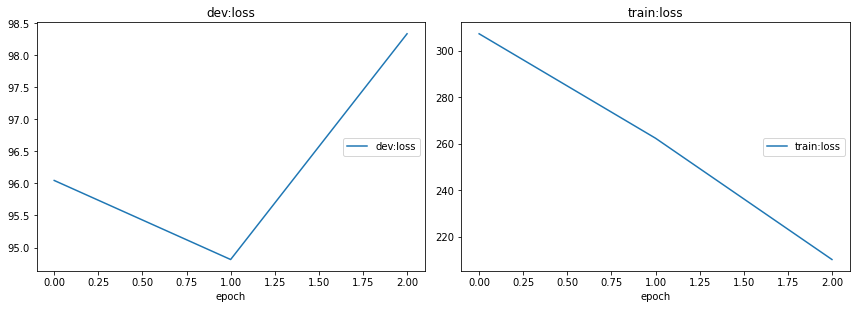

dev:loss
	dev:loss         	 (min:   94.813, max:   98.332, cur:   98.332)
train:loss
	train:loss       	 (min:  210.211, max:  307.312, cur:  210.211)
early_stopping, epoch: 3
Final dev loss 98.331804 Final Train Loss 210.211393 Final dev accuracy 0.677946
Best dev loss 94.812984 Best dev accuracy 0.673965
F1_score Sarcasm  (0.7212249208025343, 0.5575510204081633, 0.6289134438305709, None)
F1_score Non-Sarcasm  (0.6509980682549903, 0.7929411764705883, 0.714992927864215, None)


In [11]:
# weight decay and clip_grad_norm 10K data LR = 1e-5 WD = 1e-4 BATCH=32
classifier, history = trainer(classifier, optimizer, scheduler, EPOCHS, EARLY_STOP, train_dataloader, validation_dataloader, accumulation_steps=2)

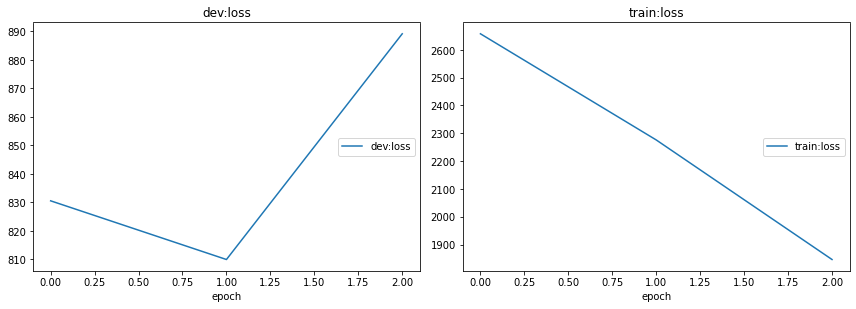

dev:loss
	dev:loss         	 (min:  809.925, max:  889.148, cur:  889.148)
train:loss
	train:loss       	 (min: 1846.122, max: 2657.656, cur: 1846.122)
early_stopping, epoch: 3
Final dev loss 889.148171 Final Train Loss 1846.121678 Final dev accuracy 0.734748
Best dev loss 809.924742 Best dev accuracy 0.748486
F1_score Sarcasm  (0.7137538483568411, 0.7865709326179581, 0.7483953305056117, None)
F1_score Non-Sarcasm  (0.7607041755130927, 0.682622846709534, 0.7195514832015396, None)


In [11]:
# weight decay and clip_grad_norm 100K data LR = 1e-5 WD = 1e-3 BATCH=32
classifier, history = trainer(classifier, optimizer, scheduler, EPOCHS, EARLY_STOP, train_dataloader, validation_dataloader, accumulation_steps=2)

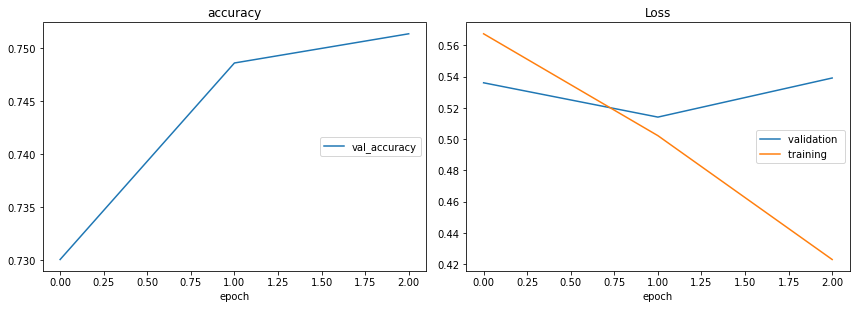

accuracy
	val_accuracy     	 (min:    0.730, max:    0.751, cur:    0.751)
Loss
	validation       	 (min:    0.514, max:    0.539, cur:    0.539)
	training         	 (min:    0.423, max:    0.567, cur:    0.423)
early_stopping, epoch: 3
Final dev loss 425.865466 Final Train Loss 1002.657343 Final dev accuracy 0.751347
Best dev loss 406.124483 Best dev accuracy 0.748593
F1_score Sarcasm  (0.7792358507409392, 0.6960925039872409, 0.7353213714093169, None)
F1_score Non-Sarcasm  (0.7291207619589167, 0.8057497447176184, 0.7655223880597015, None)


In [12]:
# weight decay and clip_grad_norm 100K data LR = 1e-5 WD = 1e-3 BATCH=32
classifier, history = trainer(classifier, optimizer, scheduler, EPOCHS, EARLY_STOP, train_dataloader, validation_dataloader)

In [5]:
classifier = AlbertForSequenceClassification.from_pretrained('albert-base-v2', output_attentions=True)
# classifier.config.classifier_dropout_prob = 0.1
classifier.load_state_dict(torch.load("checkpoint_ALBERT.pt"))
classifier.to(device)
classifier.eval()

AlbertForSequenceClassification(
  (albert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768,

In [6]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [33]:
def colorize(words, color_array):
    # words is a list of words
    # color_array is an array of numbers between 0 and 1 of length equal to words
    cmap = matplotlib.cm.get_cmap('Blues')
    template = '<span class="barcode"; style="color: black; background-color: {}">{}</span>'
    colored_string = ''
    for word, color in zip(words, color_array):
        color = matplotlib.colors.rgb2hex(cmap(color)[:3])
        colored_string += template.format(color, '&nbsp' + word + '&nbsp')
    return colored_string

In [79]:
def visualize_heatmap(sent_sp, weights):
    fig, ax = plt.subplots(figsize=(10,10))
    length = weights.shape[0]
    ax.set_xticks(np.arange(length))
    ax.set_yticks(np.arange(length))
    ax.set_xticklabels(sent_sp)
    ax.set_yticklabels(sent_sp)
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode="anchor")

    plt.imshow(weights, cmap='Blues')

predict 0 true label 1 probability tensor([[0.6027, 0.3973]], device='cuda:0') and subreddit GunsAreCool
[CLS] mother's day parade shooting: at least 12 shot during new orleans festivities[SEP] how could this happen in a state with such lax gun laws?[SEP]


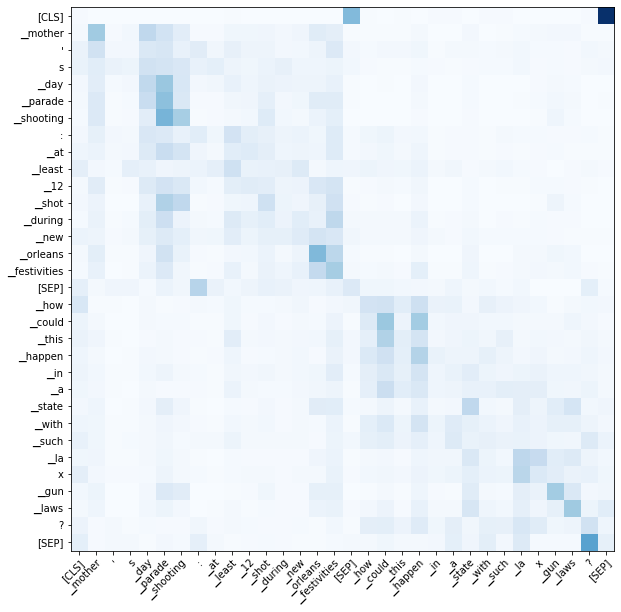

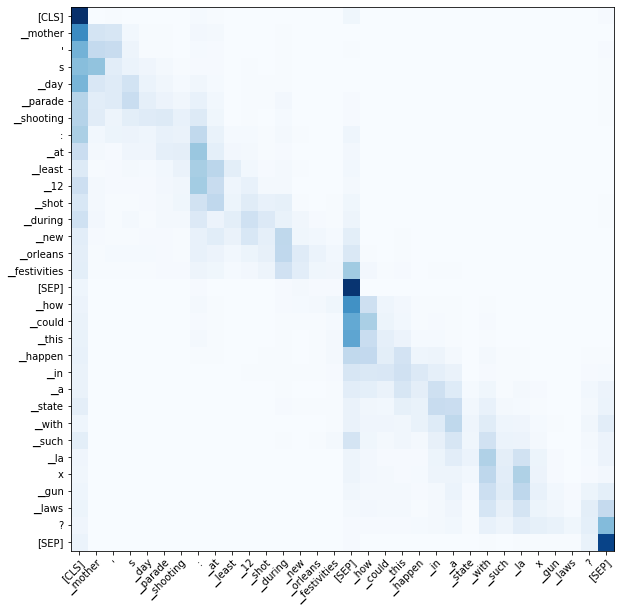

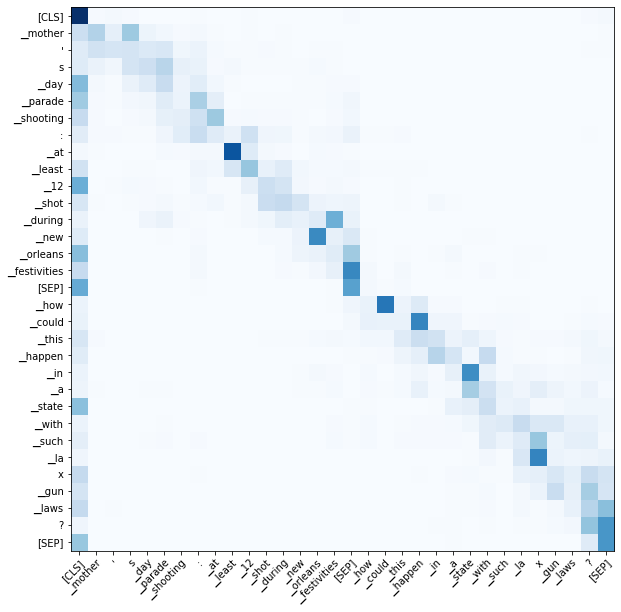

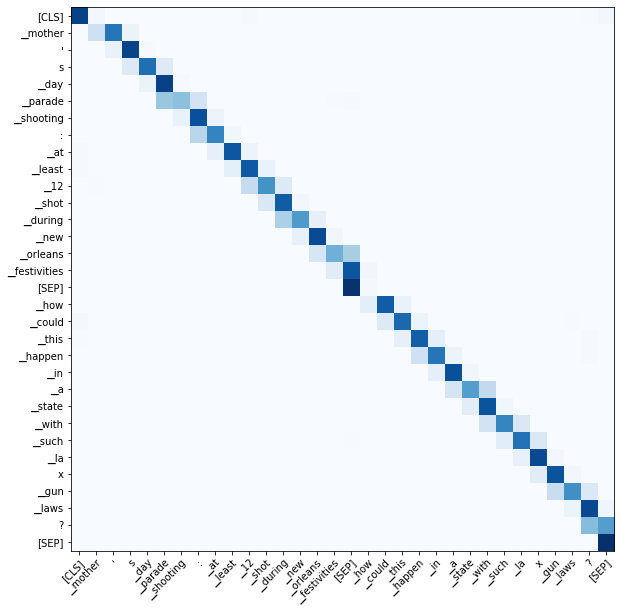

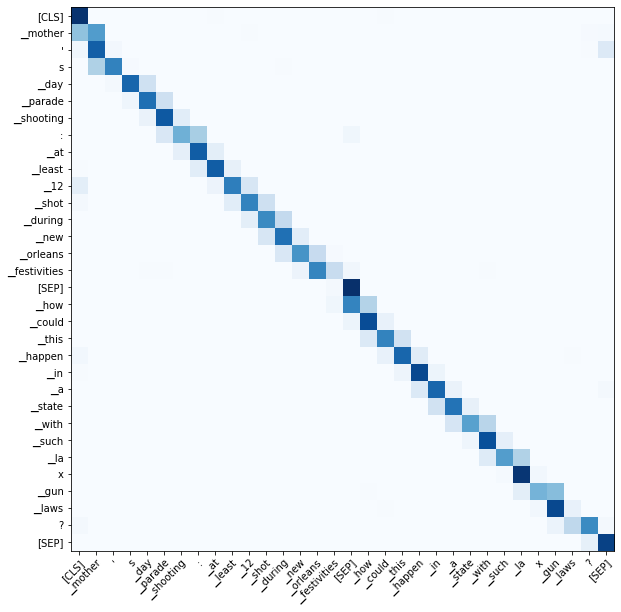

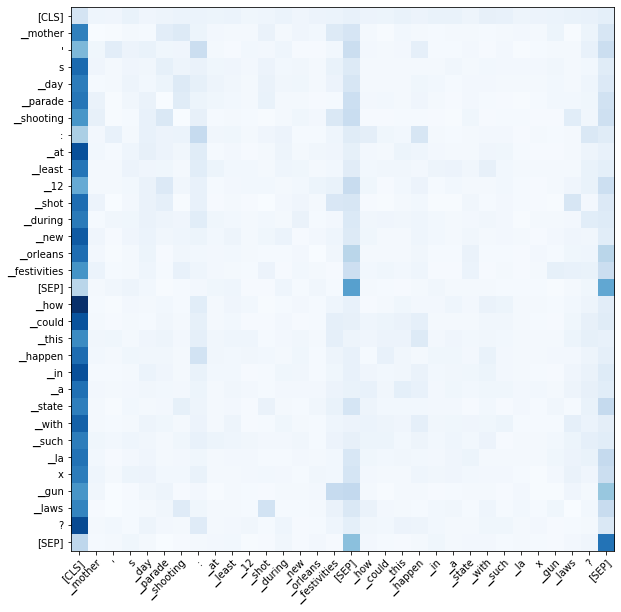

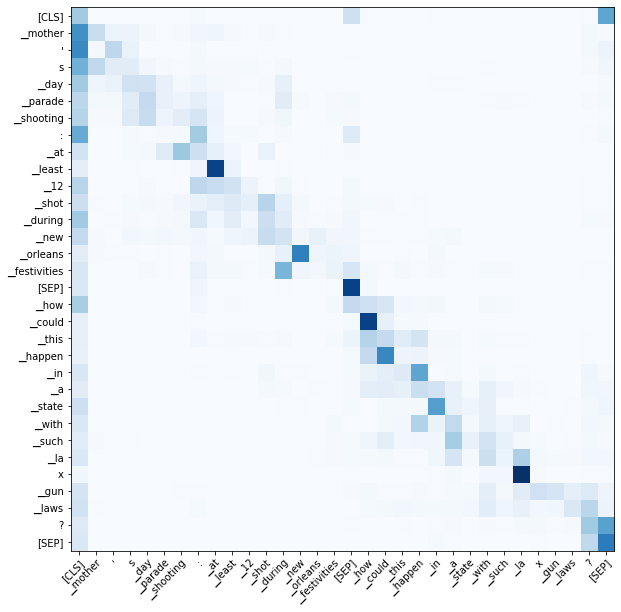

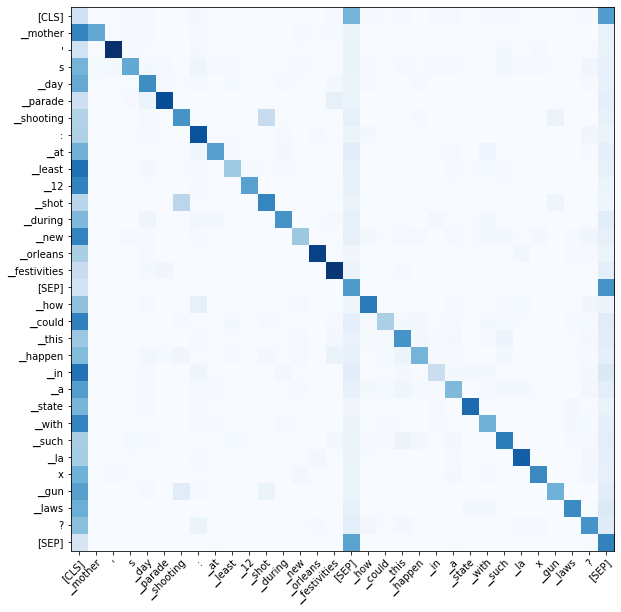

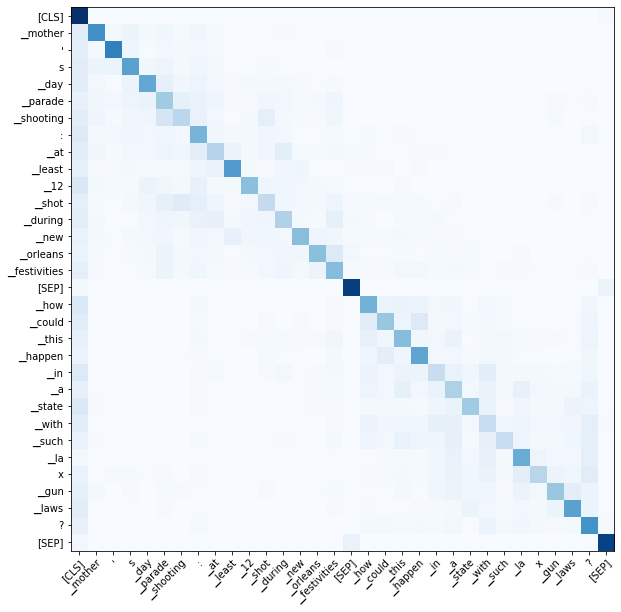

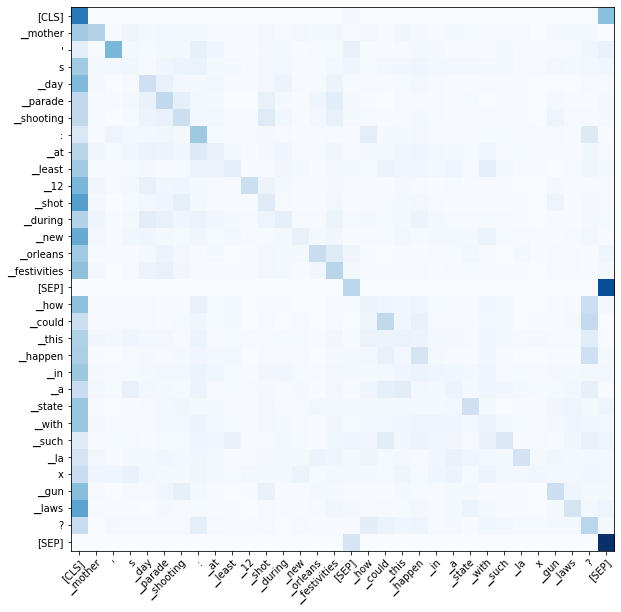

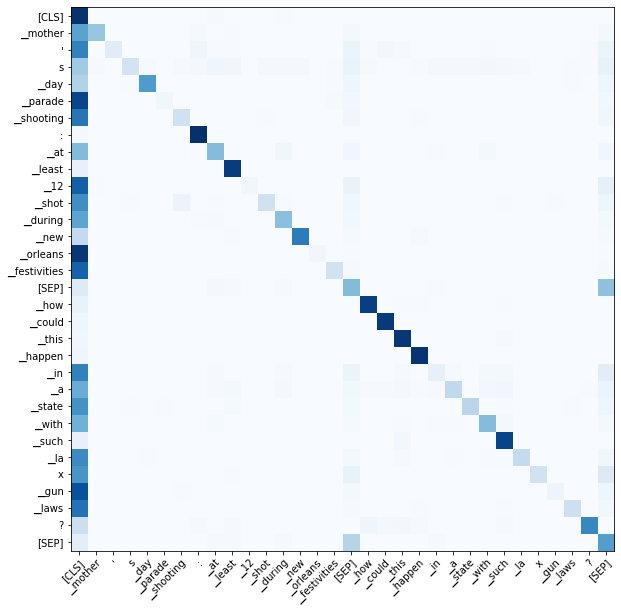

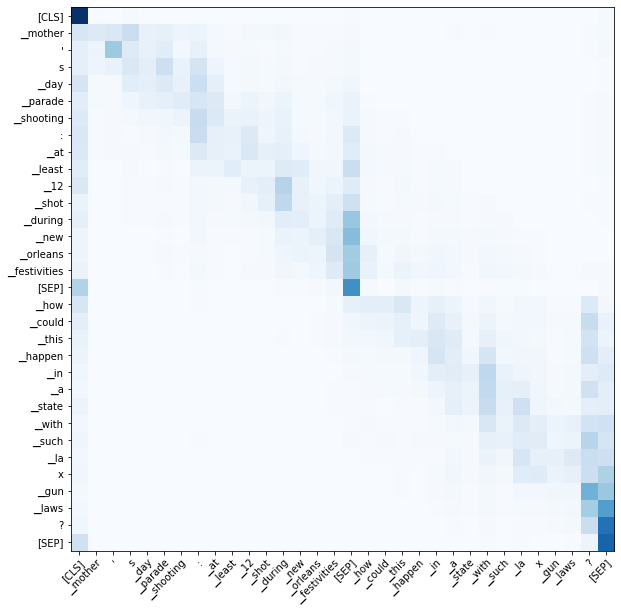

In [95]:
import pandas as pd 

show_n = 1

p = "mother's day parade shooting: at least 12 shot during new orleans festivities"
r= "how could this happen in a state with such lax gun laws?"

input_ = tokenizer.encode_plus(p, r, max_length=258, 
                               pad_to_max_length=True, return_token_type_ids=True, 
                               return_attention_mask=True, return_tensors = 'pt')
inputs = input_["input_ids"]
type_ids = input_["token_type_ids"]
mask = input_["attention_mask"]
inputs = inputs.to(device)
type_ids = type_ids.to(device)
mask = mask.to(device)
label = 1
subreddit = "GunsAreCool"

with torch.no_grad():
    logits, attentions = classifier(input_ids=inputs, attention_mask=mask, token_type_ids=type_ids)
    prob = torch.nn.functional.softmax(logits, dim=1)
    attn_weights = attentions[0].cpu().squeeze(0)
    logits = logits[0].cpu()
    y_preds = np.argmax(logits)
    print("predict {} true label {} probability {} and subreddit {}".format(y_preds, label, prob, subreddit))
    length = torch.sum(mask)
    str_sent = tokenizer.decode(inputs[0][:length])
    print(str_sent)
    for j in range(attn_weights.shape[0]):
        weights = attn_weights[j].squeeze(0)
        sent_sp = tokenizer.convert_ids_to_tokens(inputs[0][:length])
        visualize_heatmap(sent_sp, weights[:length, :length])

predict 1 true label 1 probability tensor([[0.1023, 0.8977]], device='cuda:0') and subreddit news
[CLS] states project 3 percent increase in prisoners by 2018[SEP] and here i thought crime rates were dropping[SEP]


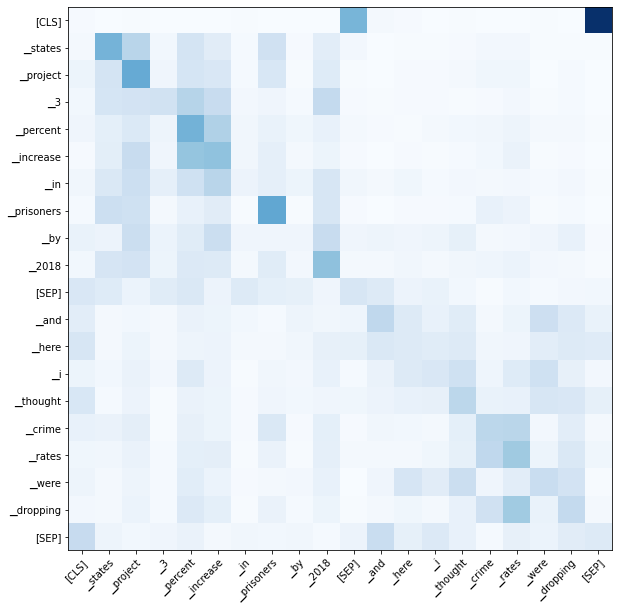

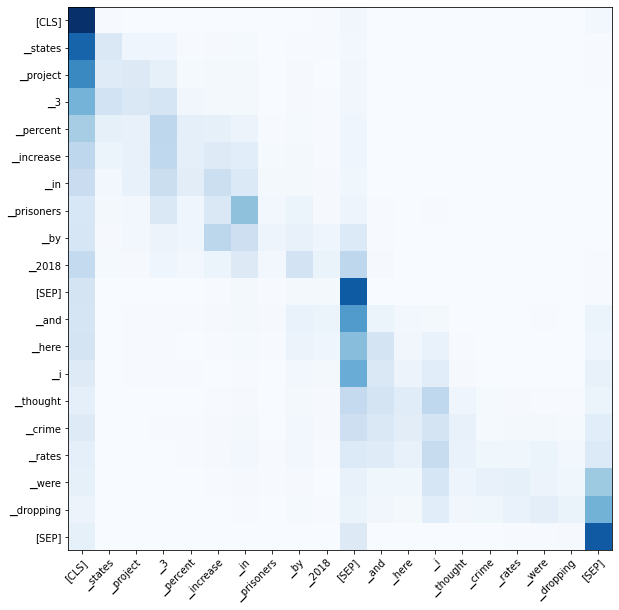

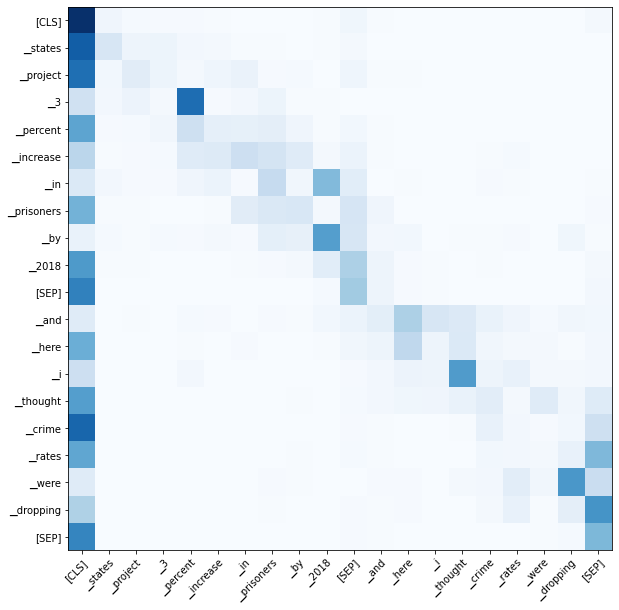

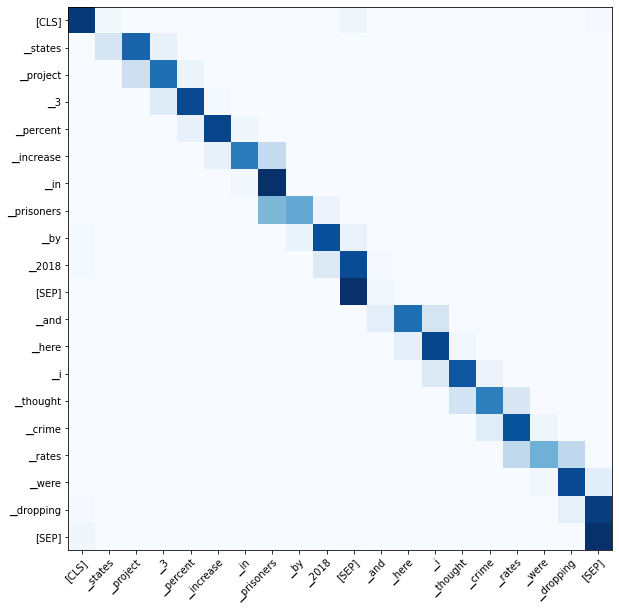

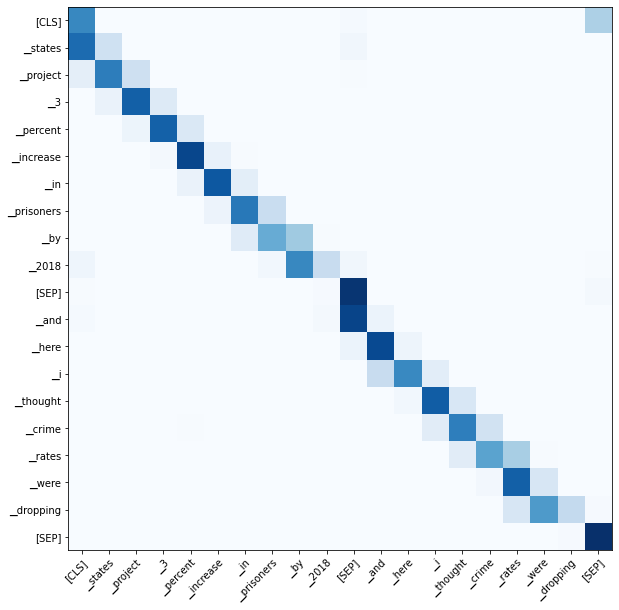

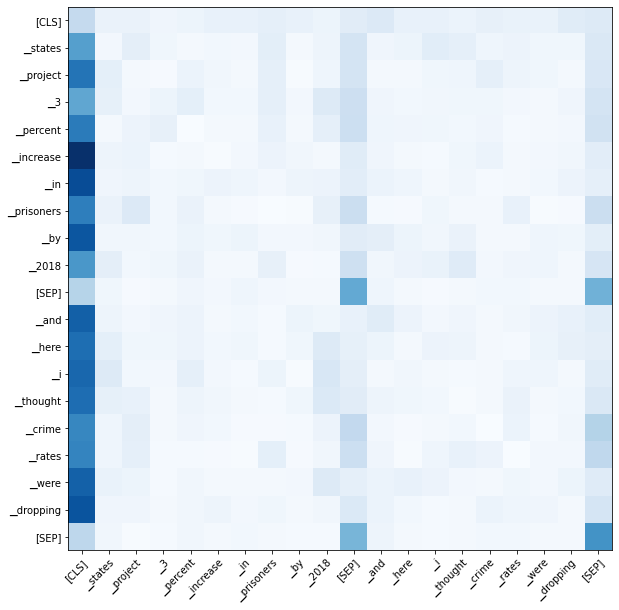

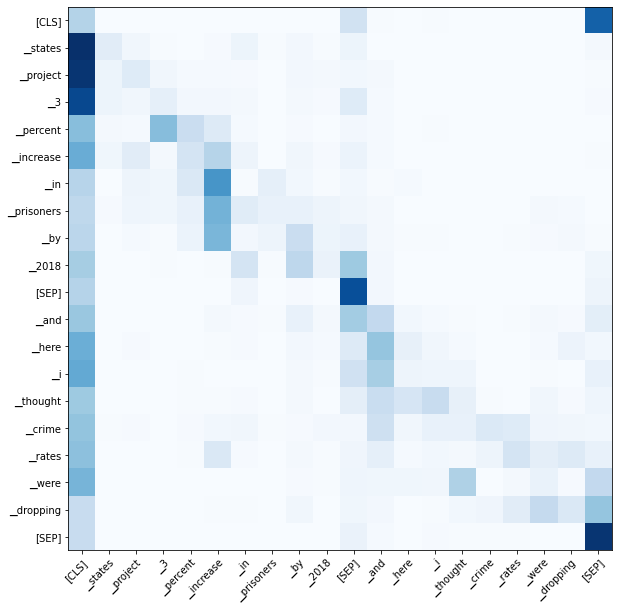

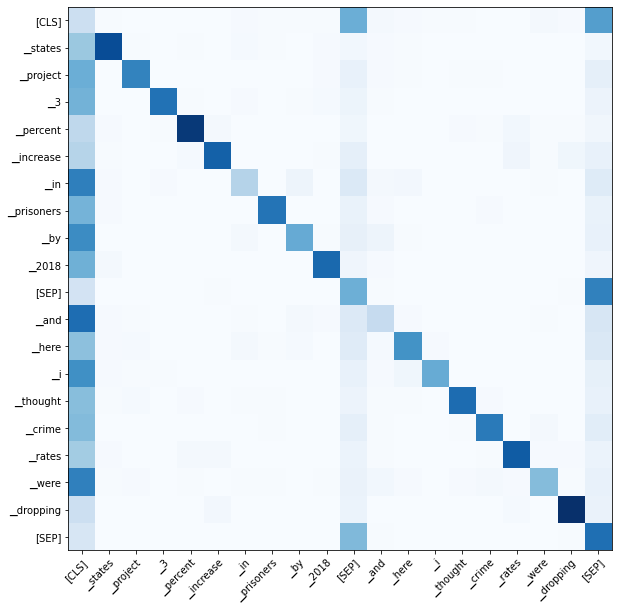

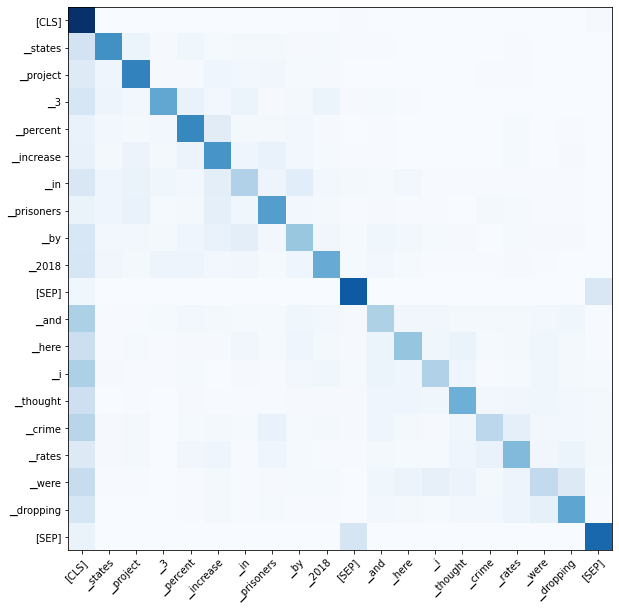

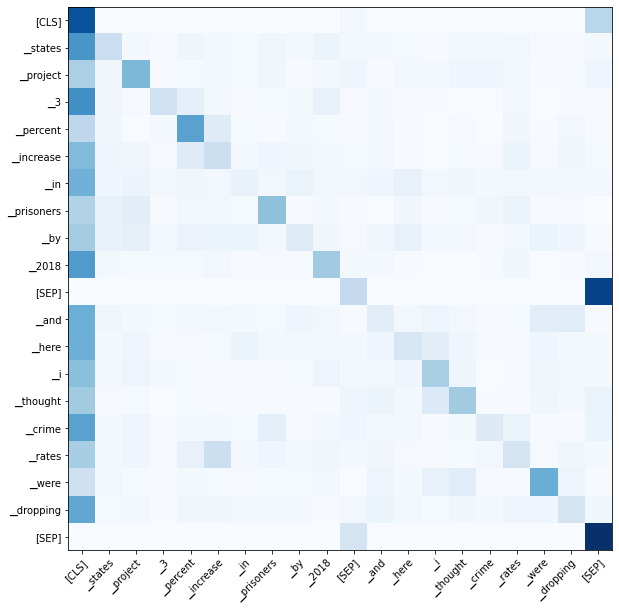

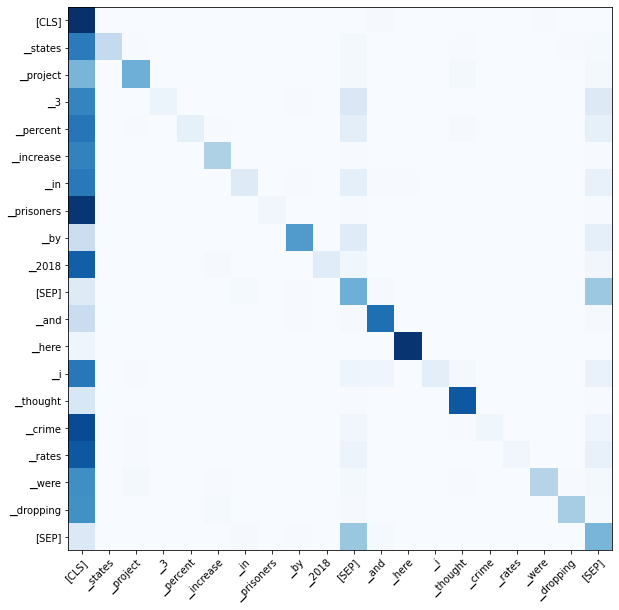

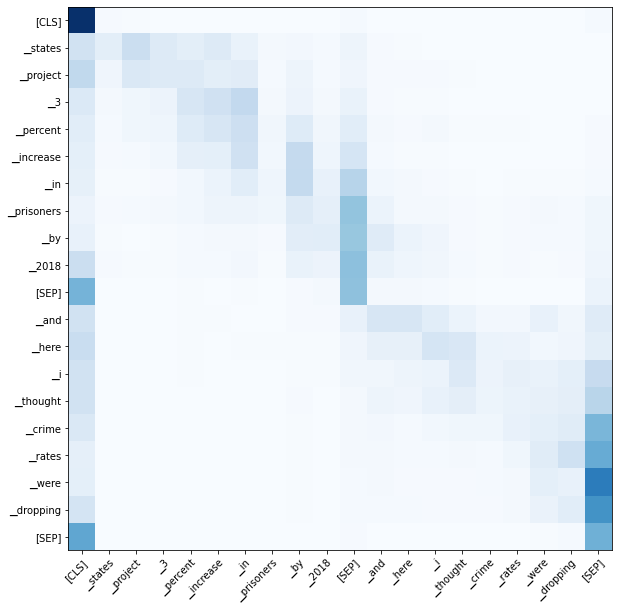

In [93]:
import pandas as pd 

show_n = 1
df = pd.read_csv("full_combine_balanced.csv")
chosen_idx = np.random.choice(len(df), replace=False, size=show_n)
df_trimmed = df.iloc[chosen_idx]
sentences = []

for i, row in df_trimmed.iterrows():
    p = 
    input_ = tokenizer.encode_plus(row["parent_comment"], row["comment"], max_length=258, 
                                   pad_to_max_length=True, return_token_type_ids=True, 
                                   return_attention_mask=True, return_tensors = 'pt')
    inputs = input_["input_ids"]
    type_ids = input_["token_type_ids"]
    mask = input_["attention_mask"]
    inputs = inputs.to(device)
    type_ids = type_ids.to(device)
    mask = mask.to(device)
    label = int(row["label"])
    
    with torch.no_grad():
        logits, attentions = classifier(input_ids=inputs, attention_mask=mask, token_type_ids=type_ids)
        prob = torch.nn.functional.softmax(logits, dim=1)
        attn_weights = attentions[0].cpu().squeeze(0)
        logits = logits[0].cpu()
        y_preds = np.argmax(logits)
        print("predict {} true label {} probability {} and subreddit {}".format(y_preds, label, prob, row["subreddit"]))
        length = torch.sum(mask)
        str_sent = tokenizer.decode(inputs[0][:length])
        print(str_sent)
        for j in range(attn_weights.shape[0]):
            weights = attn_weights[j].squeeze(0)
            sent_sp = tokenizer.convert_ids_to_tokens(inputs[0][:length])
            visualize_heatmap(sent_sp, weights[:length, :length])

In [96]:
import pandas as pd 

show_n = 256
df = pd.read_csv("full_combine_balanced.csv")
chosen_idx = np.random.choice(len(df), replace=False, size=show_n)
df_trimmed = df.iloc[chosen_idx]
sentences = []
counts = {}

for i, row in df_trimmed.iterrows():
    input_ = tokenizer.encode_plus(row["parent_comment"], row["comment"], max_length=258, 
                                   pad_to_max_length=True, return_token_type_ids=True, 
                                   return_attention_mask=True, return_tensors = 'pt')
    inputs = input_["input_ids"]
    type_ids = input_["token_type_ids"]
    mask = input_["attention_mask"]
    inputs = inputs.to(device)
    type_ids = type_ids.to(device)
    mask = mask.to(device)
    label = int(row["label"])
    
    with torch.no_grad():
        logits, attentions = classifier(input_ids=inputs, attention_mask=mask, token_type_ids=type_ids)
        prob = torch.nn.functional.softmax(logits, dim=1)
        attn_weights = attentions[0].cpu().squeeze(0)
        logits = logits[0].cpu()
        y_preds = np.argmax(logits)
#         print("predict {} true label {} probability {} and subreddit {}".format(y_preds, label, prob, row["subreddit"]))
        if row["subreddit"] not in counts:
            counts[row["subreddit"]] = {}
            counts[row["subreddit"]]["correct"] = 0
            counts[row["subreddit"]]["incorrect"] = 0
            if y_preds == label:
                counts[row["subreddit"]]["correct"] += 1
            else:
                counts[row["subreddit"]]["incorrect"] += 1
            print("predict {} true label {} probability {} and subreddit {}".format(y_preds, label, prob, row["subreddit"]))
            length = torch.sum(mask)
            str_sent = tokenizer.decode(inputs[0][:length])
            print(str_sent)
print(counts)

predict 1 true label 1 probability tensor([[0.1215, 0.8785]], device='cuda:0') and subreddit politics
[CLS] and obama said slavery because it's accurate; it's an accurate occurrence in time that was worse for black people. your whataboutisms and "nobody was alive" nonsense add nothing to the conversation.[SEP] obama, the great uniter.[SEP]
predict 0 true label 0 probability tensor([[0.5254, 0.4746]], device='cuda:0') and subreddit hockey
[CLS] what, matthews is still up? come on, it's like 4 in the morning in finland, give him a break sn.[SEP] 5am source: me because fuck sleep i'll watch hockey screw u timezones[SEP]
predict 1 true label 1 probability tensor([[0.0877, 0.9123]], device='cuda:0') and subreddit whowouldwin
[CLS] everyone knows you are the biggest namor fan ever[SEP] nah, superman 4 life[SEP]
predict 0 true label 0 probability tensor([[0.7109, 0.2891]], device='cuda:0') and subreddit polandball
[CLS] how many furlongs is a block?[SEP] the same number as fathoms to leagues!

In [32]:
show_n = 3
for batch in validation_dataloader:
    b_inputs = batch[0].to(device)
    b_labels = batch[1].to(device)
    b_mask = batch[2].to(device)
    b_ids = batch[3].to(device)
    
    with torch.no_grad():
        loss, logits = classifier(input_ids=b_inputs, attention_mask=b_mask, token_type_ids=b_ids, labels=b_labels)                    
        label_ids = b_labels.cpu().numpy()
        prob = torch.nn.functional.softmax(logits, dim=1)
        logits = logits.detach().cpu().numpy()
        y_preds = np.argmax(logits, axis=1)
        for i in range(len(b_inputs)):
            sent = b_inputs[i]
            print()
            print("predict {} true label {} probability {}".format(y_preds[i], label_ids[i], prob[i]))
            length = torch.sum(b_mask[i])
#             print(length, b_mask[i])
            str_sent = tokenizer.decode(sent[:length])
#             str_sent1 = tokenizer.decode(sent)
            print(str_sent)
    show_n -= 1
    if show_n == 0:
        break


predict 0 true label 0 probability tensor([0.6615, 0.3385], device='cuda:0')
[CLS] tmartin is in even deeper shit now[SEP] i wonder if he'll discover some new websites soon.[SEP]

predict 0 true label 0 probability tensor([0.7692, 0.2308], device='cuda:0')
[CLS] those pupils are never a good sign[SEP] i think it's kickin in...[SEP]

predict 0 true label 0 probability tensor([0.9389, 0.0611], device='cuda:0')
[CLS] painting of taylor swift[SEP] "portrait of jillian" by jeremy mann[SEP]

predict 1 true label 1 probability tensor([0.0886, 0.9114], device='cuda:0')
[CLS] mats hummels: "i don't necessarily have to play in the champions league to be happy."[SEP] we should sell him, wehave no need for players who lack ambition[SEP]

predict 1 true label 1 probability tensor([0.2160, 0.7840], device='cuda:0')
[CLS] whoever wrote the novelization of those movies did a really good job.[SEP] nah, he added hundreds of pointless pages where nothing happens.[SEP]

predict 1 true label 1 probability

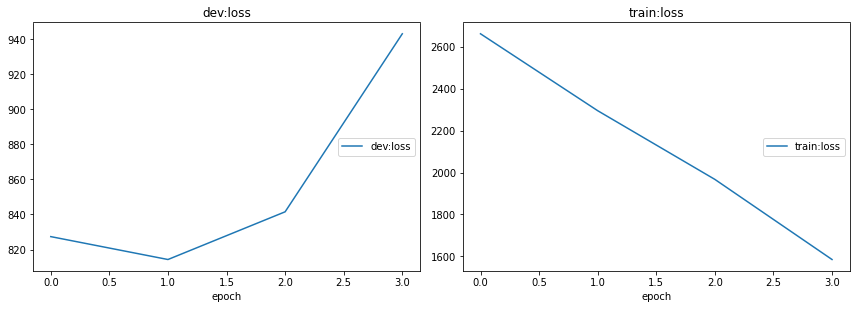

dev:loss
	dev:loss         	 (min:  814.288, max:  943.158, cur:  943.158)
train:loss
	train:loss       	 (min: 1585.171, max: 2662.045, cur: 1585.171)
early_stopping, epoch: 4
Final dev loss 943.158111 Final Train Loss 1585.171021 Final dev accuracy 0.739597
Best dev loss 814.288270 Best dev accuracy 0.746835
F1_score Sarcasm  (0.7423363034415107, 0.7257832480818415, 0.7339664578702769, None)
F1_score Non-Sarcasm  (0.7368461420463261, 0.7529586958225566, 0.7448152885994497, None)


In [10]:
# weight decay and clip_grad_norm 100K data
classifier, history = trainer(classifier, optimizer, scheduler, EPOCHS, EARLY_STOP, train_dataloader, validation_dataloader)

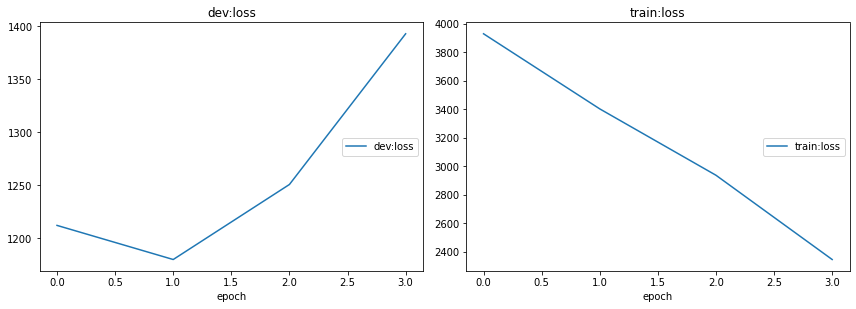

dev:loss
	dev:loss         	 (min: 1180.156, max: 1392.651, cur: 1392.651)
train:loss
	train:loss       	 (min: 2344.014, max: 3928.812, cur: 2344.014)
early_stopping, epoch: 4
Final dev loss 1392.650813 Final Train Loss 2344.013594 Final dev accuracy 0.744884
Best dev loss 1180.155633 Best dev accuracy 0.757727
F1_score Sarcasm  (0.7508798944126704, 0.7263538674327056, 0.7384132821372559, None)
F1_score Non-Sarcasm  (0.7391745259101511, 0.7629265229223362, 0.7508627349987124, None)


In [10]:
# weight decay and clip_grad_norm_ 150K data
classifier, history = trainer(classifier, optimizer, scheduler, EPOCHS, EARLY_STOP, train_dataloader, validation_dataloader)

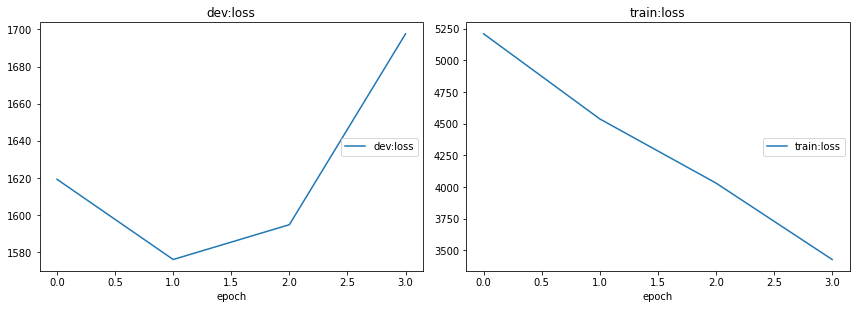

dev:loss
	dev:loss         	 (min: 1575.976, max: 1697.647, cur: 1697.647)
train:loss
	train:loss       	 (min: 3426.833, max: 5209.079, cur: 3426.833)
early_stopping, epoch: 4
Final dev loss 1697.646930 Final Train Loss 3426.832769 Final dev accuracy 0.749629
Best dev loss 1575.976371 Best dev accuracy 0.752820
F1_score Sarcasm  (0.7489262776311123, 0.7515916010913836, 0.7502565721954685, None)
F1_score Non-Sarcasm  (0.7503477327822596, 0.7476735437373777, 0.749008251348778, None)


In [11]:
# weight decay and clip_grad_norm 200K data LR=1e-5
classifier, history = trainer(classifier, optimizer, scheduler, EPOCHS, EARLY_STOP, train_dataloader, validation_dataloader)

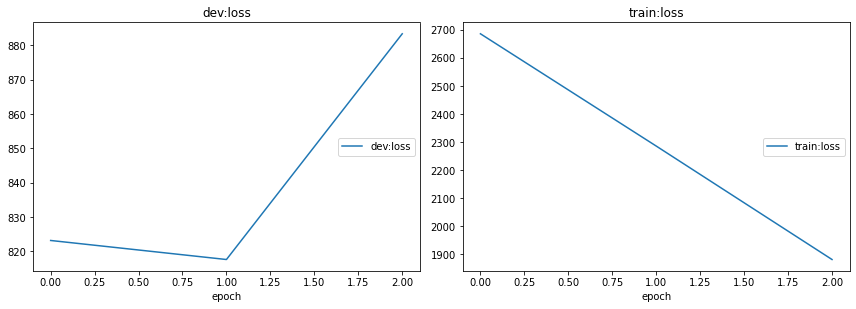

dev:loss
	dev:loss         	 (min:  817.605, max:  883.312, cur:  883.312)
train:loss
	train:loss       	 (min: 1881.716, max: 2685.197, cur: 1881.716)
early_stopping, epoch: 3
Final dev loss 883.312419 Final Train Loss 1881.715915 Final dev accuracy 0.737065
Best dev loss 817.604788 Best dev accuracy 0.742117
F1_score Sarcasm  (0.7535266118563393, 0.696225811610427, 0.7237438177964342, None)
F1_score Non-Sarcasm  (0.7230242053076699, 0.7768899334116726, 0.7489898417733468, None)


In [11]:
# weight decay and clip_grad_norm 100K data
classifier, history = trainer(classifier, optimizer, scheduler, EPOCHS, EARLY_STOP, train_dataloader, validation_dataloader, accumulation_steps=1)